# Counting objects

## Load data

We first load the sample image and display it for reference.

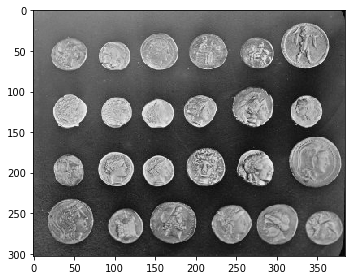

In [1]:
from skimage import data        #this is where skimage keeps sample images
from skimage.io import imshow   #convenient method for displaying image
import matplotlib.pyplot as plt #Jupyter needs plt.show() to display image; imshow() not so convenient anymore

image = data.coins() 
imshow(image)
plt.show()

## 0. Cleaning up the image

Next we equalize the input image.

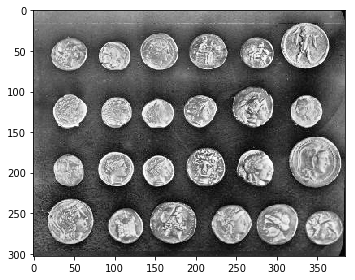

In [2]:
from skimage import exposure

equalized = exposure.equalize_adapthist(image) #I find that 'adapthist' works better than just 'equalize_hist()'
imshow(equalized)
plt.show()

With the image equalized, we can find a threshold and apply it.

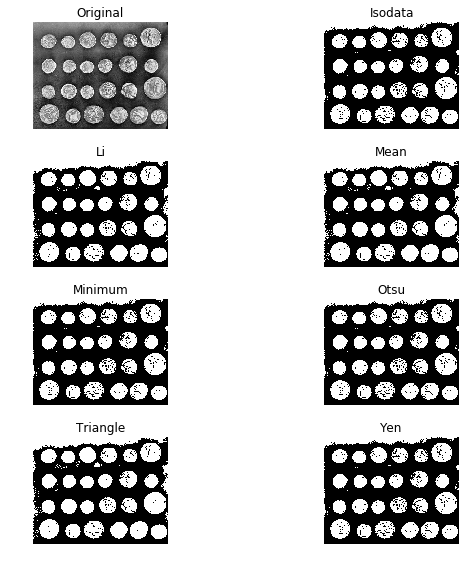

In [3]:
from skimage import filters

#We can take a look at all available thresholds applied to our equalized image
fig, ax = filters.try_all_threshold(equalized, figsize=(10, 8), verbose=False)
plt.show()

#and then choose our favorite
threshold = filters.threshold_li(equalized)
threshed = equalized > threshold

With the threshold applied, we can remove objects touching the boundary.

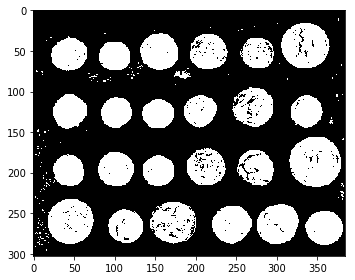

In [4]:
from skimage import segmentation

cleared = segmentation.clear_border(threshed)
imshow(cleared)
plt.show()

Next, we 'sweep away' all the small objects scattered around the image.

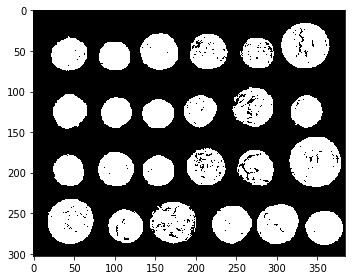

In [5]:
from skimage import morphology

swept = morphology.remove_small_objects(cleared, min_size = 150)
imshow(swept)
plt.show()

And then apply the morphological closing algorithm:

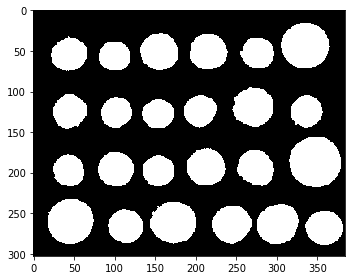

In [6]:
closed = morphology.binary_closing(swept, morphology.disk(3))  #faster closing for binary images
imshow(closed)
plt.show()

## 1. Measuring the coins

With our image relatively cleaned-up, we can use skimage's 'measure' module to label the distinct regions and measure their properties.  For this assignment, we are interested in the area and eccentricity of each coin.  Conveniently, these are both properties that can be measured by skimage.  To be clear, skimage gives the 'first eccentricity' $e = \sqrt{(1 - \frac{b^2}{a^2}}$, where $a$ is the length of the semi-major axis and $b$ is the length of the semi-minor axis.  A perfect circle has an eccentricity of zero.

We will plot the semi-major/minor axes for each coin, along with its eccentricity and area (in pixels).

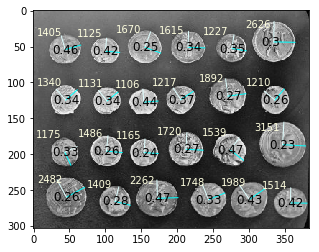

In [7]:
import numpy as np
from skimage import measure

#label image regions and then measure their properties
labeled = measure.label(closed)        
regions = measure.regionprops(labeled)

#plot the original image
fig, ax = plt.subplots()
ax.imshow(image, cmap = plt.cm.gray)

#loop each of the measured regions and plot its properties over the original image
for region in regions:
    #center of region
    y0, x0 = region.centroid
    """Angle between the X-axis and the major axis of the ellipse 
       that has the same second-moments as the region. Ranging from 
       -pi/2 to pi/2 in counter-clockwise direction."""
    orientation = region.orientation
    
    #finding endpoints to plot the semi-major/minor axes
    x1 = x0 + np.cos(orientation) * 0.5 * region.major_axis_length
    y1 = y0 - np.sin(orientation) * 0.5 * region.major_axis_length
    x2 = x0 - np.sin(orientation) * 0.5 * region.minor_axis_length
    y2 = y0 - np.cos(orientation) * 0.5 * region.minor_axis_length
    
    #plotting semi-major/minor axes
    ax.plot((x0, x1), (y0, y1), color = 'cyan', linewidth=1)
    ax.plot((x0, x2), (y0, y2), color = 'lightcyan', linewidth=1)
    
    #plotting area
    ax.text(x0 - 40, y0-20, str(region.area), color = 'lightyellow')
    #plotting eccentricity
    ax.text(x0 - 18, y0+5, str(round(region.eccentricity, 2)), color = 'black', fontsize = 12) 
    
plt.show()

Great!  As you can see, the semi-major/minor axes are plotted in cyan/light-cyan, the area (in pixels) is above each coin, and the eccentricity is at the center of each coin.  It appears that the less rugged (more circular) coins have lower eccentricity, as you'd expect.

# Panorama stitching
Following the [tutorial](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb) given by Stefan & friends.


## 'First things first'
Import NumPy and matplotlib, then define a utility function to compare multiple images

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()
    plt.show()

## Load data

Panoramic images are kept in the 'images' directory; replace "Zermatt" with 'JDW' to stitch the original tutorial images.  Also, you can try 'BigSur', but this algorithm often has time matching the leftmost image to the center image.  The number of keypoints in the ORB feature detection step can be adjusted, but matching does not work well every time.

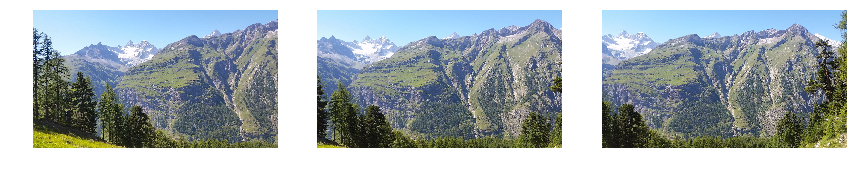

In [58]:
import skimage.io as io

pano_imgs = io.ImageCollection('images/Zermatt*')
compare(*pano_imgs, figsize=(12, 10))


## 0. Pre-processing

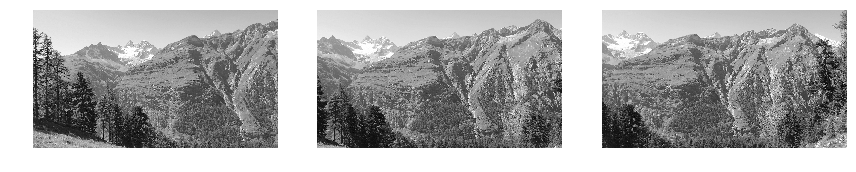

In [59]:
from skimage.color import rgb2gray

pano0, pano1, pano2 = [rgb2gray(im) for im in pano_imgs]

# View the results
compare(pano0, pano1, pano2, figsize=(12, 10))


## 1. Feature detection and matching

We need to estimate a projective transformation that relates these images together. The steps will be

  1. Define one image as a target or destination image, which will remain anchored while the others are warped
  2. Detect features in all three images
  3. Match features from left and right images against the features in the center, anchored image.
  
In this three-shot series, the middle image pano1 is the logical anchor point.

We detect "Oriented FAST and rotated BRIEF" (ORB) features in both images.

In [60]:
from skimage.feature import ORB

# Initialize ORB
# ~1000 keypoints is needed for proper warping 
# of my leftmost image
orb = ORB(n_keypoints=800, fast_threshold=0.05)

# Detect keypoints in pano0
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

# Detect keypoints in pano1
orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Detect keypoints in pano2
orb.detect_and_extract(pano2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

Match features from images 0 <-> 1 and 1 <-> 2.

In [61]:
from skimage.feature import match_descriptors

# Match descriptors between left/right images and the center
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

Inspect these matched features side-by-side using the convenience function skimage.feature.plot_matches.  This conventience function is raising a ValueError from an invalid RGBA argument; I'm not sure how to fix this.  I'll comment out this plotting step, but it would be useful when attempting to match images for the first time.

In [96]:
"""from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01)
ax.axis('off')
plt.show()"""

"from skimage.feature import plot_matches\nfig, ax = plt.subplots(1, 1, figsize=(15, 12))\n\n# Best match subset for pano0 -> pano1\nplot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01)\nax.axis('off')\nplt.show()"

# 2. Transform estimation

To filter out the false matches, we apply RANdom SAmple Consensus (RANSAC), a powerful method of rejecting outliers available in skimage.transform.ransac. The transformation is estimated iteratively, based on randomly chosen subsets, finally selecting the model which corresponds best with the majority of matches.

We need to do this twice, once each for the transforms left -> center and right -> center.

In [63]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from 
#   * source (image to be registered): pano0
#   * target (reference image): pano1, our middle frame registration target
src = keypoints0[matches01[:, 0]][:, ::-1]
dst = keypoints1[matches01[:, 1]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

# Select keypoints from 
#   * source (image to be registered): pano2
#   * target (reference image): pano1, our middle frame registration target
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

Once again, ValueErrors are raised when calling plot_matches(), so I'll comment out this plotting.

In [64]:
"""fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01[inliers01])

ax.axis('off');"""

"fig, ax = plt.subplots(1, 1, figsize=(15, 12))\n\n# Best match subset for pano0 -> pano1\nplot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01[inliers01])\n\nax.axis('off');"

In [65]:
"""fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano2 -> pano1
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12[inliers12])

ax.axis('off');"""

"fig, ax = plt.subplots(1, 1, figsize=(15, 12))\n\n# Best match subset for pano2 -> pano1\nplot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12[inliers12])\n\nax.axis('off');"

## 3. Warping

Next, we produce the panorama itself. We must warp, or transform, two of the three images so they will properly align with the stationary image.

### Extent of output image

The first step is to find the shape of the output image to contain all three transformed images. To do this we consider the extents of all warped images.

In [66]:
from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = pano1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

### Apply estimated transforms

Warp the images with skimage.transform.warp according to the estimated models. A shift, or translation is needed to place as our middle image in the middle - it isn't truly stationary.

Values outside the input images are initially set to -1 to distinguish the "background", which is identified for later use.

In [67]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)

# Translate pano1 into place
pano1_warped = warp(pano1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0

Warp left panel into place

In [68]:
# Warp pano0 (left) to pano1
transform01 = (model_robust01 + offset1).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0

Warp right panel into place

In [69]:
# Warp pano2 (right) to pano1 
transform12 = (model_robust12 + offset1).inverse
pano2_warped = warp(pano2, transform12, order=3,
                    output_shape=output_shape, cval=-1)

pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
pano2_warped[~pano2_mask] = 0      # Return background values to 0

Inspect the warped images:

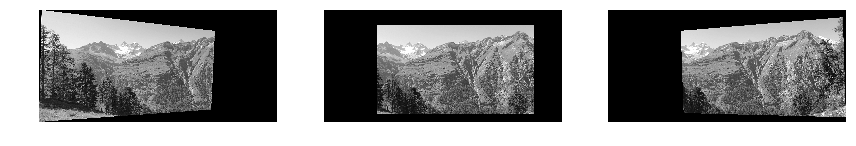

In [70]:
compare(pano0_warped, pano1_warped, pano2_warped, figsize=(12, 10))

# 4. Seamless image stitching with MCP

Among other things, skimage.graph allows you to

  - start at any point on an array
  - find the path to any other point in the array
  - the path found minimizes the sum of values on the path.

The array is called a cost array, while the path found is a minimum-cost path or MCP.

To accomplish this we need

  - Starting and ending points for the path
  - A cost array (a modified difference image)
  
This method is so powerful that, with a carefully constructed cost array, the seed points are essentially irrelevant. It just works!

### Define seed points

In [71]:
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 3],
              [xmax, ymax // 3]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 3],
              [xmax, 2*ymax // 3]]

### Construct cost array

This utility function exists to give a "cost break" for paths from the edge to the overlap region.

In [72]:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

Use this function to generate the cost array.

In [73]:
# Start with the absolute value of the difference image.
# np.abs is necessary because we don't want negative costs!
costs01 = generate_costs(np.abs(pano0_warped - pano1_warped),
                         pano0_mask & pano1_mask)

Allow the path to "slide" along top and bottom edges to the optimal horizontal position by setting top and bottom edges to zero cost.

In [74]:
costs01[0,  :] = 0
costs01[-1, :] = 0

Our cost array now looks like this:

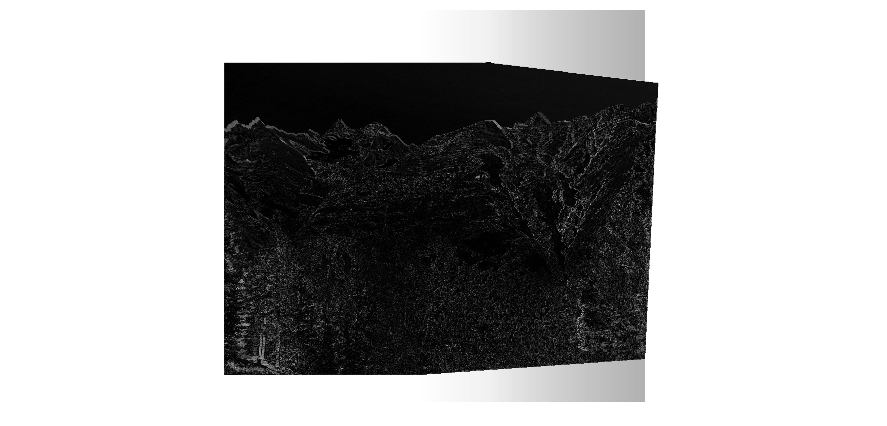

In [75]:
fig, ax = plt.subplots(figsize=(15, 12))

ax.imshow(costs01, cmap='gray', interpolation='none')

ax.axis('off');
plt.show()

### Find the MCP

Use skimage.graph.route_through_array to find an optimal path through the cost array

In [76]:
from skimage.graph import route_through_array

# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

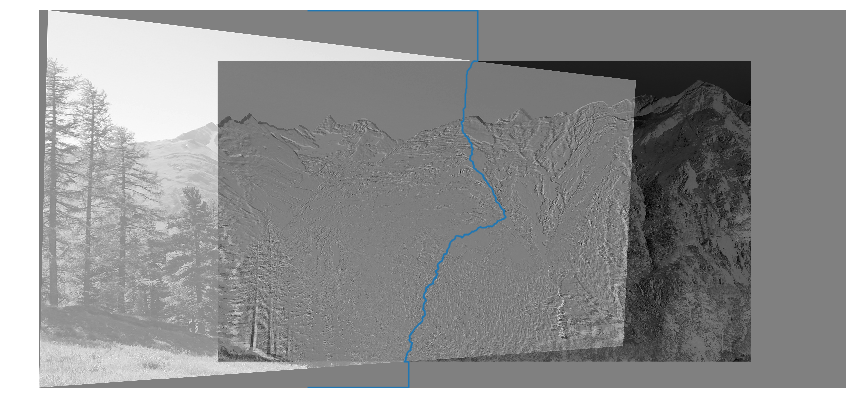

In [77]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano0_warped - pano1_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');
plt.show()

### Filling the mask

Turn that path into a mask, which will be 1 where we want the left image to show through and zero elsewhere. We need to fill the left side of the mask with ones over to our path.

Note: This is the inverse of NumPy masked array conventions (numpy.ma), which specify a negative mask (mask == bad/missing) rather than a positive mask as used here (mask == good/selected).

Place the path into a new, empty array.

In [78]:
# Start with an array of zeros and place the path
mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1

Ensure the path appears as expected (

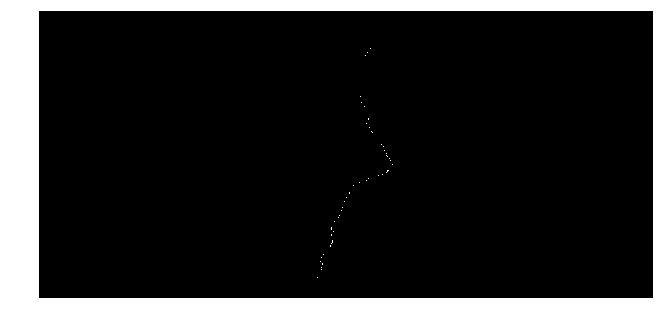

In [79]:
fig, ax = plt.subplots(figsize=(11, 11))

# View the path in black and white
ax.imshow(mask0, cmap='gray')

ax.axis('off');
plt.show()

Label the various contiguous regions in the image using skimage.measure.label

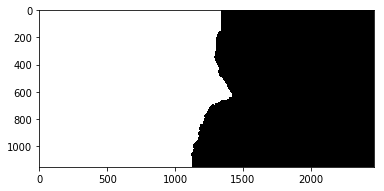

In [80]:
from skimage.measure import label

# Labeling starts with one at point (0, 0)
mask0 = (label(mask0, connectivity=1, background=-1) == 1)

# The result
plt.imshow(mask0, cmap='gray');
plt.show()

### Repeat for the other two images

First start with the cost array

In [81]:
# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                         pano1_mask & pano2_mask)

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0

Add a constraint to prevent crossing our first path.

In [82]:
costs12[mask0 > 0] = 1

Check the result

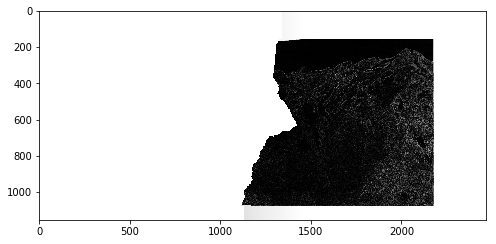

In [83]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(costs12, cmap='gray');
plt.show()

Compute the MCP

In [84]:
# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

Does it look good?

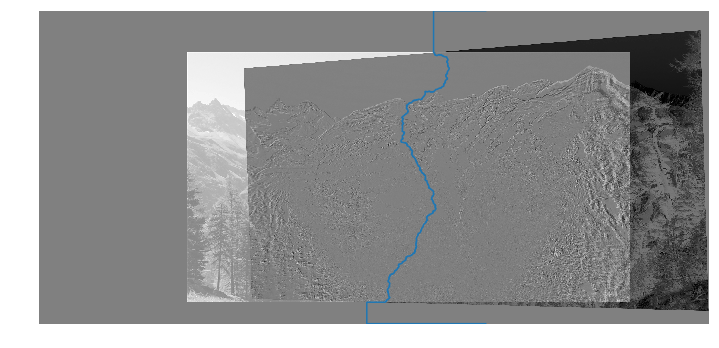

In [85]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano1_warped - pano2_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);

ax.axis('off');
plt.show()

Initialize the mask by placing the path in a new array

In [86]:
mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1

Fill the right side this time, again using skimage.measure.label - the label of interest is 2

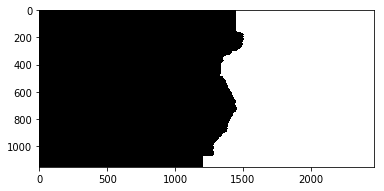

In [87]:
mask2 = (label(mask2, connectivity=1, background=-1) == 3)

# The result
plt.imshow(mask2, cmap='gray');
plt.show()

### Final mask

The last mask for the middle image is one of exclusion - it will be displayed everywhere mask0 and mask2 are not.

In [88]:
mask1 = ~(mask0 | mask2).astype(bool)

Define a convenience function to place masks in alpha channels

In [89]:
def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

Obtain final, alpha blended individual images and inspect them

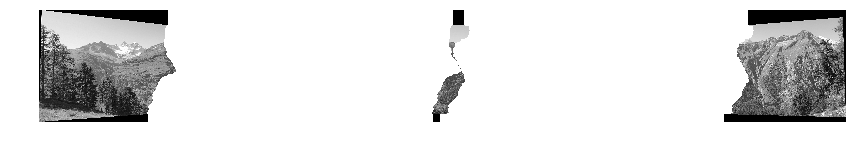

In [90]:
pano0_final = add_alpha(pano0_warped, mask0)
pano1_final = add_alpha(pano1_warped, mask1)
pano2_final = add_alpha(pano2_warped, mask2)

compare(pano0_final, pano1_final, pano2_final, figsize=(12, 12))

Plot all three together and view the results!

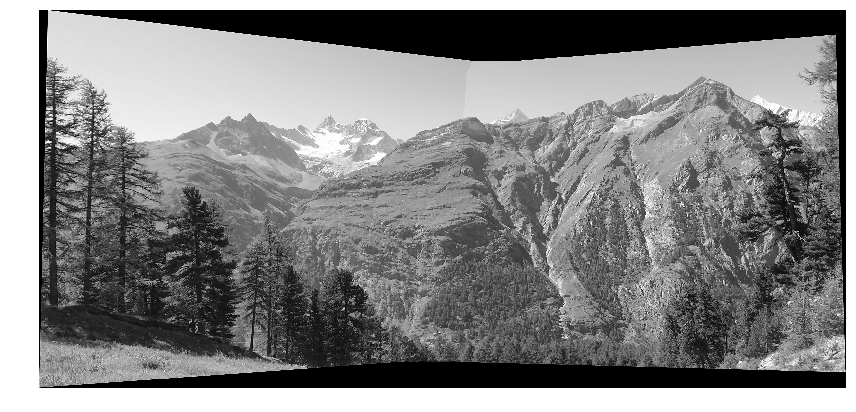

In [91]:
fig, ax = plt.subplots(figsize=(12, 12))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');
plt.show()

# Colors!

We converted to grayscale for ORB feature detection, back in the initial preprocessing steps. Since we stored our transforms and masks, adding color is straightforward!

Transform the colored images

In [92]:
# Identical transforms as before, except
#   * Operating on original color images
#   * filling with cval=0 as we know the masks
pano0_color = warp(pano_imgs[0], (model_robust01 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

pano1_color = warp(pano_imgs[1], offset1.inverse, order=3,
                   output_shape=output_shape, cval=0)

pano2_color = warp(pano_imgs[2], (model_robust12 + offset1).inverse, order=3,
                   output_shape=output_shape, cval=0)

Then apply the custom alpha channel masks

In [93]:
pano0_final = add_alpha(pano0_color, mask0)
pano1_final = add_alpha(pano1_color, mask1)
pano2_final = add_alpha(pano2_color, mask2)

Did it work?

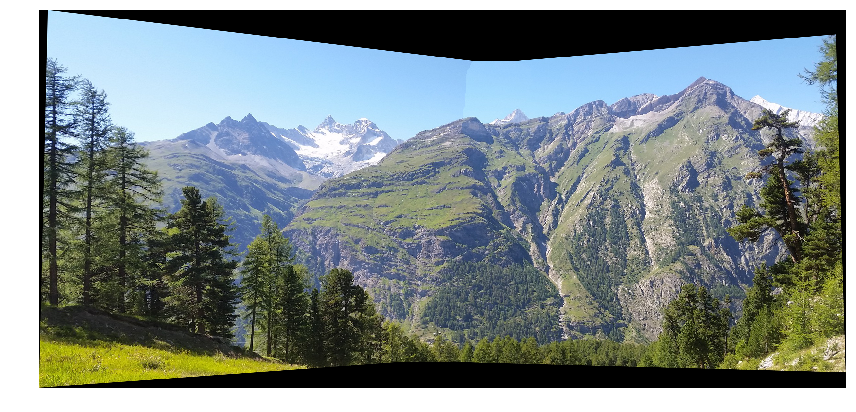

In [94]:
fig, ax = plt.subplots(figsize=(12, 12))

# Turn off matplotlib's interpolation
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')

fig.tight_layout()
ax.axis('off');
plt.show()

Yes! Let's save it.

In [95]:
from skimage.color import gray2rgb

# Start with empty image
pano_combined = np.zeros_like(pano0_color)

# Place the masked portion of each image into the array
# masks are 2d, they need to be (M, N, 3) to match the color images
pano_combined += pano0_color * gray2rgb(mask0)
pano_combined += pano1_color * gray2rgb(mask1)
pano_combined += pano2_color * gray2rgb(mask2)


# Save the output - precision loss warning is expected
# moving from floating point -> uint8
io.imsave('./pano-advanced-output.png', pano_combined)

C:\Users\nickc\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
